# Finding the Band Gap 

## Equations
Densidad Óptica
\begin{equation}
O.D = \frac{\alpha l}{ln(10)}
\end{equation}
K (numero de onda) 
\begin{equation}
k = \frac{\alpha \lambda}{4\pi}
\end{equation}
Transmitancia y Reflectancia
\begin{align}
T = (1-R)^{2} e^{-\alpha l}\\
R =  1 -e^{\frac{1}{2}\alpha l}T^{\frac{1}{2}}    
\end{align}
Indice de refracción
\begin{equation}
R = \frac{(n-1)^2 + k^2}{(n+1)^2+k^2}
\end{equation}


In [147]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

## Variables

Importación de datos

In [308]:
class material:
            
    def __init__(self, name,l,refraction_coefficient):
        data = pd.read_csv('data.csv')
        self.name = name
        self.l = l
        self.refraction_coefficient = refraction_coefficient
        self.wavelength = pd.to_numeric(data["Wavelength"], errors='coerce')
        transmitancia = pd.to_numeric(data[f'{self.name}_T'], errors='coerce')
        reflectancia =  pd.to_numeric(data[f'{self.name}_R'], errors='coerce')
        absorbancia =  pd.to_numeric(data[f'{self.name}_Abs'], errors='coerce')
        self. reflectancia = reflectancia/10
        self.transmitancia = transmitancia/100
        self.absorbancia =absorbancia
       
        
    def R_theoric_calc(self):
        '''
        Calcula la transmitancia con  R = 1 - e**(0.5*self.absorbancia*l)*transmitancia
        '''
        size = self.absorbancia.size
        R = np.empty(size, dtype=float)
        R = np.abs(1 - np.abs(np.power(np.e,0.5*self.absorbancia*self.l)*np.sqrt(self.transmitancia)))
        return R
    def T_theoric_calc(self):
        size = self.absorbancia.size
        T = np.empty(size, dtype=float)
        T = np.multiply(np.power((1 - self.reflectancia),2),np.power(np.e,-self.absorbancia*self.l))
        return T
    def k_calc(self):
        '''
        Calcula el numero de onda  como k = (alpha*lambda)/4pi
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        k = np.empty(size, dtype=float)
        k = np.multiply(self.absorbancia,self.wavelength)*(1/(4*np.pi*np.power(10,9)))#Numero de onda
        return k 
    def do_calc(self):
        '''
        Calcula la densidad optica  como  d.o = (absorbancia*self.l)/(np.log(10))#Espesor del material
        devuelve un dataframe de pandas
        '''
        size = self.absorbancia.size
        do = np.empty(size, dtype=float)
        do = 0.434*(self.absorbancia*self.l)#Espesor del material
        return do
    def indice_de_refrac(self, r, k, n_min, n_max, tol=0.01):
        """
        Calcula el índice de refracción n para cada punto usando búsqueda por barrido.
        
        r: arreglo de reflectancia (0.1)
        k: arreglo del coeficiente de extinción
        n_min, n_max: límites inferiores y superiores de búsqueda
        tol: tolerancia de coincidencia |R_calc - R_med|
        """
    
    
        # Convertir r y k a arrays numpy
        r = np.asarray(r, dtype=float)
        k = np.asarray(k, dtype=float)
    
        size = len(r)
    
        # arreglo donde guardaremos n por longitud de onda
        n_arr = np.full(size, np.nan)
    
        # paso del barrido
        step = (n_max - n_min) / 1000     # más fino que 100 → más estable
    
        for i in range(size):
    
            # si el dato es inválido, se salta
            if np.isnan(r[i]) or np.isnan(k[i]):
                continue
    
            n = n_min
            found = False
    
            while n <= n_max:

                # reflectancia teórica (normal incidence)
                r_calc = ((n - 1)**2 + k[i]**2) / ((n + 1)**2 + k[i]**2)
    
                # diferencia absoluta
                dif = abs(r_calc - r[i])
    
                # condición de match
                if dif <= tol:
                    n_arr[i] = n
                    found = True
                    break
    
                n += step
    
            # si no encontró n dentro del rango
            if not found:
                # fallback
                if i > 0 and not np.isnan(n_arr[i-1]):
                    n_arr[i] = n_arr[i-1]   # continuar con n anterior
                else:
                    n_arr[i] = self.refraction_coefficient  # valor por defecto del material
    
        return n_arr

        

    def graph_abs(self):
            '''
            Gráfica la  la longitud de onda vs  absorbancia
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.absorbancia,label=self.name,s=3, color='darkgoldenrod')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Absorbancia")
            plt.title("Absorbancia del "+self.name)
            plt.legend()
            plt.show()

    def graph_T(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.transmitancia,label=self.name,s=3, color='orange')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Transmitancia")
            plt.title("Transmitancia del "+self.name)
            plt.legend()
            plt.show()   
    
    def graph_R(self):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,self.reflectancia,label=self.name,s=3, color='teal')
            plt.xlabel("longitud de onda (nm)")
            plt.ylabel("Reflectancia")
            plt.title("Reflectancia experimental del  "+self.name)
            plt.legend()
            plt.show()   
    def graphT_expVsTheoric(self, t_t):
        '''
        Gráfica longitud de onda vs transmitancia experimental y teórica
        incluyendo barras de error discretas en cada punto.
        '''
    
        error = abs(self.transmitancia - t_t)
    
        plt.style.use('Solarize_Light2')
        plt.figure(figsize=(10,5))
    
        # curva experimental
        plt.scatter(self.wavelength, self.transmitancia, label="experimental", s=8, color='aliceblue')
    
        # curva teórica
        plt.scatter(self.wavelength, t_t, label="teórica", s=8, color='teal')
    
        # barras de error discretas
    
        plt.xlabel("longitud de onda (nm)")
        plt.ylabel("Transmitancia")
        plt.title("T experimental vs T teórica — " + self.name)
        plt.legend()
        plt.show()
        plt.scatter(self.wavelength,error, label="error", s=8, color='red')
        plt.xlabel("wavelength")
        plt.ylabel("error")
        plt.title("difference")
        plt.show()



    def graphR_expVsTheoric(self, r_t):
        '''
        Gráfica longitud de onda vs reflectancia experimental y teórica
        incluyendo barras de error discretas en cada punto.
        '''
    
        error = abs(self.reflectancia - r_t)
    
        plt.style.use('Solarize_Light2')
        plt.figure(figsize=(10,5))
    
        # curva experimental
        plt.scatter(self.wavelength, self.reflectancia, label="experimental", s=8, color='aliceblue')
    
        # curva teórica
        plt.scatter(self.wavelength, r_t, label="teórica", s=8, color='teal')
    
        # barras de error (muy finas y discretas)
    
        plt.xlabel("longitud de onda (nm)")
        plt.ylabel("Reflectancia")
        plt.title("R experimental vs R teórica — " + self.name)
        plt.legend()
        plt.show()
        plt.style.use('Solarize_Light2')
        plt.figure(figsize=(10,5))
    
    
        plt.scatter(self.wavelength,error, label="experimental", s=8, color='red')
        plt.xlabel("wavelength")
        plt.ylabel("error")
        plt.title("difference")
        plt.show()
    
        
        
        




    def multiple_graph_absT(self):
            '''
            Gráfica la longitud de onda vs la transmitancia y reflectancia.
            Usa un eje Y secundario para la reflectancia debido a escalas diferentes.
            '''
            plt.style.use('Solarize_Light2')
            fig, ax1 = plt.subplots(figsize=(10, 5))
            color_t = 'orange'
            ax1.set_xlabel("longitud de onda (nm)")
            ax1.set_ylabel("Transmitancia (%)", color=color_t)  # Etiqueta para el eje 1
            ax1.scatter(self.wavelength, self.transmitancia, label="Transmitancia", s=4,color=color_t)
            color_r = 'teal'
            ax1.scatter(self.wavelength, self.reflectancia, label="Reflectancia", s=4,color=color_r)
            # 4. Título
            plt.title("Comparación P. ópticas del " + self.name)
            fig.tight_layout()  
            plt.show()
 
    def graph_R_Theoric(self,R):
            '''
            Gráfica la  la longitud de onda vs la transmitancia 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,R,label=self.name,s=4, color='teal')
            plt.xlabel("Wavelength")
            plt.ylabel("Reflectancia Teorica")
            plt.title("Reflectancia teorica de "+self.name)
            plt.legend()
            plt.show()
    def graph_do(self,k,do):
            '''
            Gráfica de la absorbancia vs densidad optica 
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(k,do,label=self.name,s=4, color='gold')
            plt.xlabel("absorbancia")
            plt.ylabel("densidad optica")
            plt.title("densidad optica del "+self.name)
            plt.legend()
            plt.show()
    def graph_k(self,k):  
            '''
            Gráfica la longitud de onda vs el numero de onda k
            '''
            plt.style.use('Solarize_Light2')
            plt.figure(figsize=(10,5))
            plt.scatter(self.wavelength,k,label=self.name,s=4, color='lightseagreen')
            plt.xlabel("coeficiente de extinción")
            plt.ylabel("K")
            plt.title("coeficiente de extinción del "+self.name)
            plt.legend()
            plt.show()
       

    

In [309]:
vidrio =  material("Vidrio",0.98,1.5)#0.98 mm
acetato = material("Acetato",0.1,1.475)#0.1mm
cristal = material("Cristal",0.2,1.5)#0.2 mm

In [310]:
def maxMinMean(material,materialPropiedad,propiedad):
    maxi = np.round(np.max(materialPropiedad),3)
    mini = np.round(np.min(materialPropiedad),3)
    prom = np.round(np.mean(materialPropiedad),3)
    print(f'para el {material.name} la {propiedad} el maximo es {maxi}, el minimo es {mini} y el promedio {prom}')
    

In [287]:
print(" ")
print("Transmitancia")
print(" ")
maxMinMean(vidrio,vidrio.transmitancia,"transmitancia")
maxMinMean(cristal,cristal.transmitancia,"transmitancia")
maxMinMean(acetato,acetato.transmitancia,"transmitancia")
print(" ")
print("Reflectancia")
print(" ")
maxMinMean(vidrio,vidrio.reflectancia,"reflectancia")
maxMinMean(cristal,cristal.reflectancia,"reflectancia")
maxMinMean(acetato,acetato.reflectancia,"reflectancia")
print(" ")
print("Absorbancia")
print(" ")
maxMinMean(vidrio,vidrio.absorbancia,"absorbancia")
maxMinMean(cristal,cristal.absorbancia,"absorbancia")
maxMinMean(acetato,acetato.absorbancia,"absorbancia")


 
Transmitancia
 
para el Vidrio la transmitancia el maximo es 0.901, el minimo es 0.802 y el promedio 0.883
para el Cristal la transmitancia el maximo es 0.915, el minimo es 0.769 y el promedio 0.89
para el Acetato la transmitancia el maximo es 0.908, el minimo es 0.577 y el promedio 0.842
 
Reflectancia
 
para el Vidrio la reflectancia el maximo es 0.1, el minimo es 0.001 y el promedio 0.053
para el Cristal la reflectancia el maximo es 0.229, el minimo es 0.026 y el promedio 0.067
para el Acetato la reflectancia el maximo es 0.351, el minimo es 0.067 y el promedio 0.102
 
Absorbancia
 
para el Vidrio la absorbancia el maximo es 0.096, el minimo es 0.045 y el promedio 0.054
para el Cristal la absorbancia el maximo es 0.111, el minimo es 0.039 y el promedio 0.05
para el Acetato la absorbancia el maximo es 0.241, el minimo es 0.042 y el promedio 0.076


# Gráficas individuales para cada material

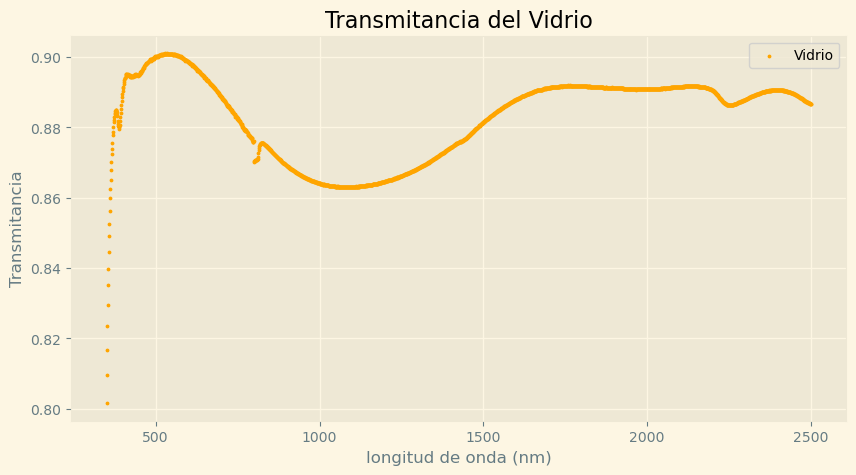

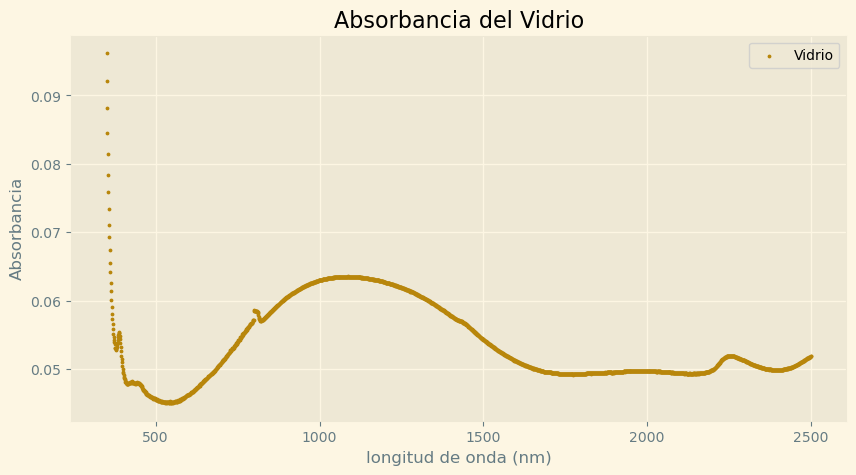

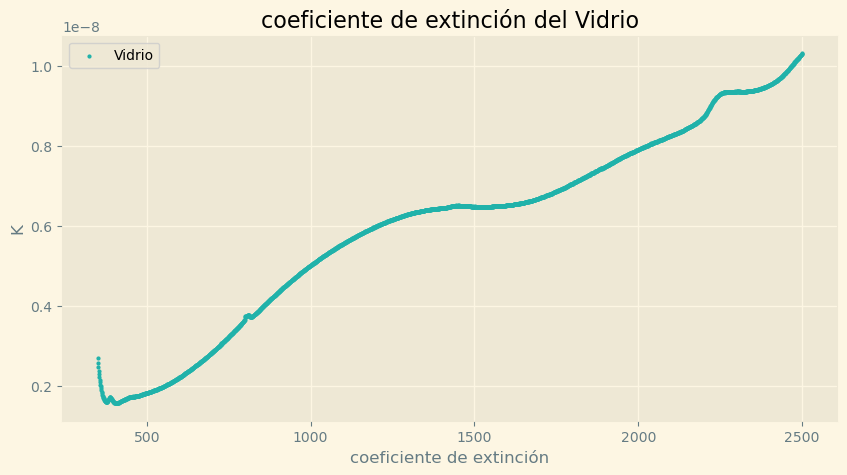

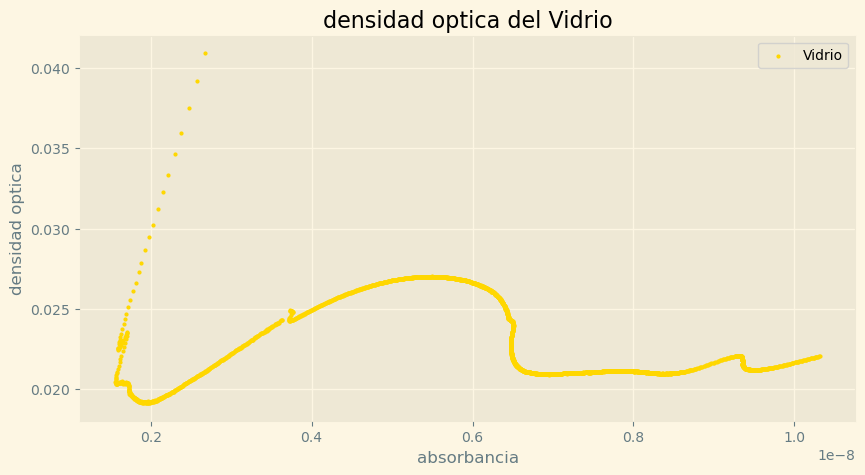

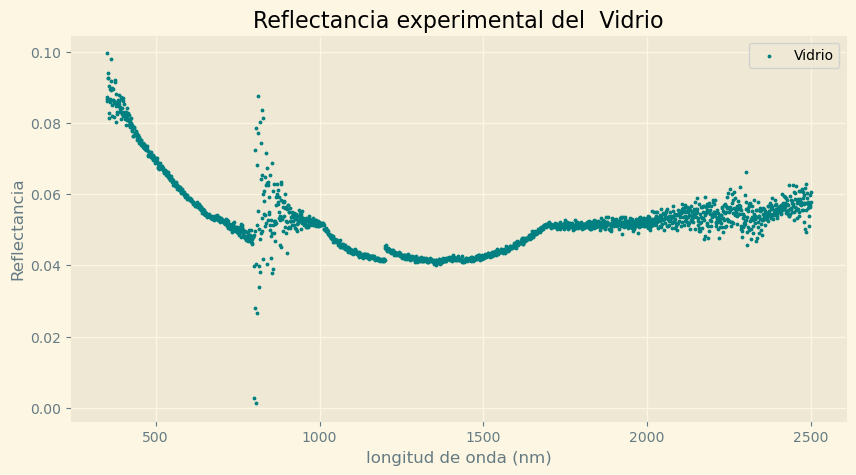

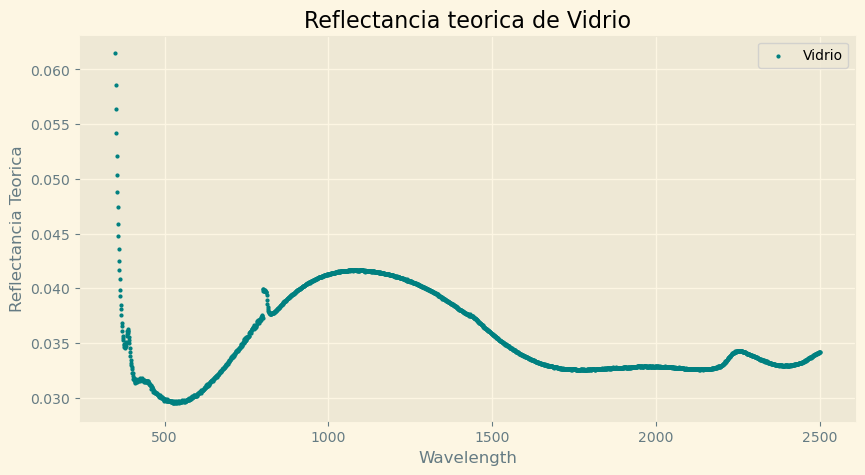

In [278]:
k_vidrio=vidrio.k_calc()
r_teorica_vidrio = vidrio.R_theoric_calc()
vidrio.graph_T()
vidrio.graph_abs()
vidrio.graph_k(k_vidrio)
vidrio.graph_do(k_vidrio,vidrio.do_calc())
vidrio.graph_R()
vidrio.graph_R_Theoric(r_teorica_vidrio)

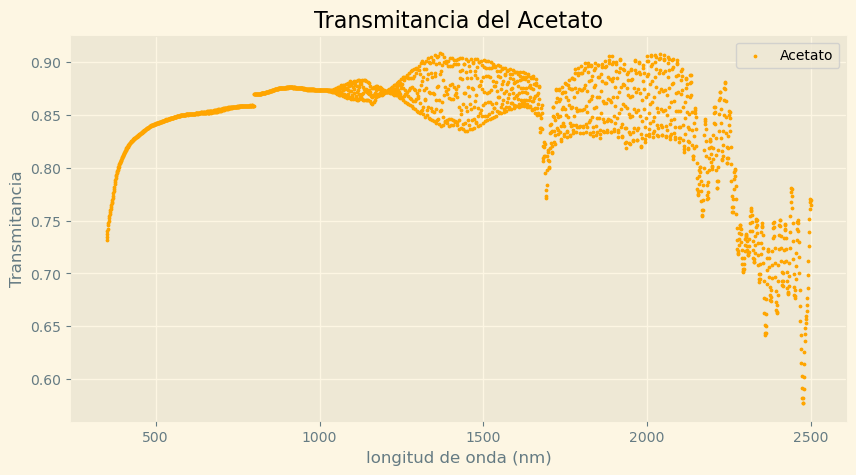

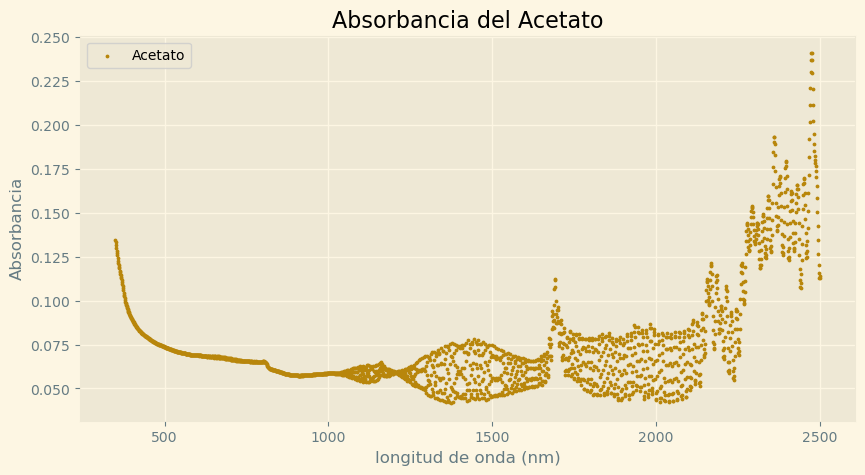

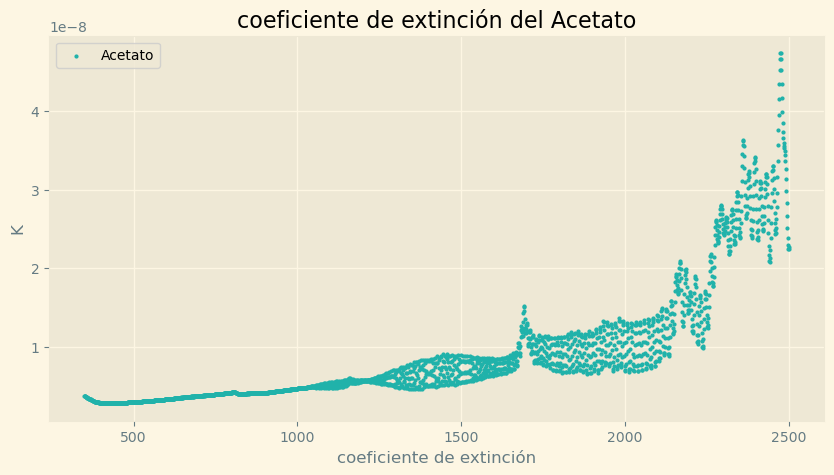

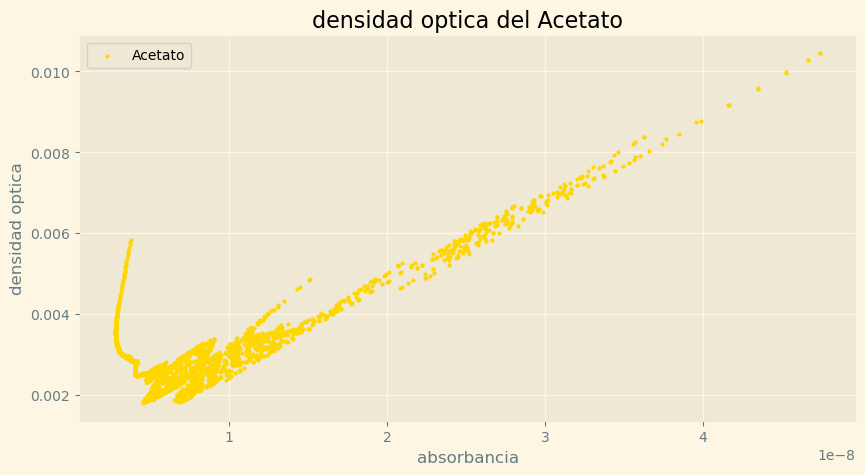

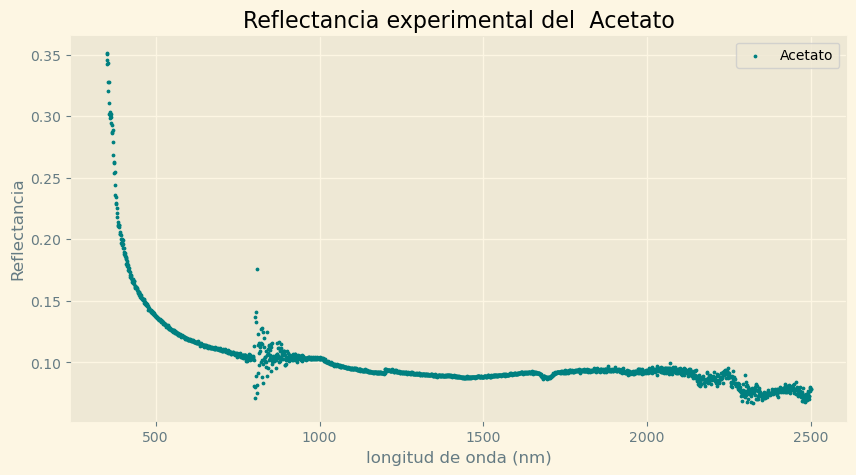

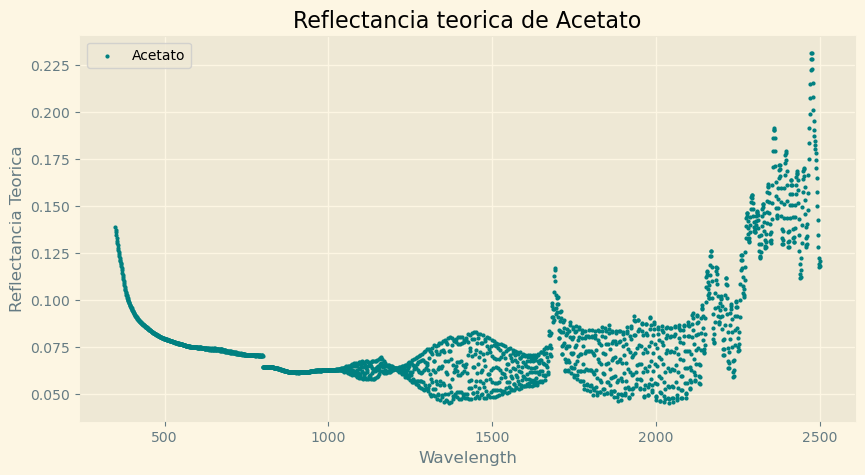

In [279]:
k_acetato=acetato.k_calc()
r_teorica_acetato = acetato.R_theoric_calc()
acetato.graph_T()
acetato.graph_abs()
acetato.graph_k(k_acetato)
acetato.graph_do(k_acetato,acetato.do_calc())
acetato.graph_R()
acetato.graph_R_Theoric(r_teorica_acetato)


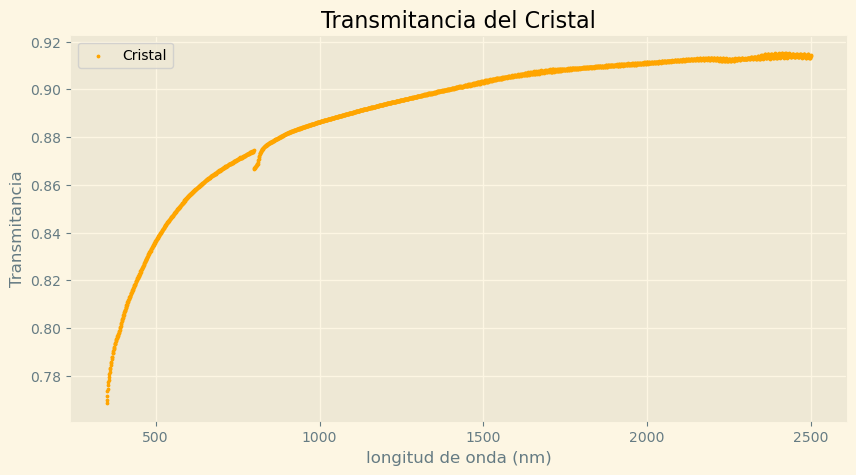

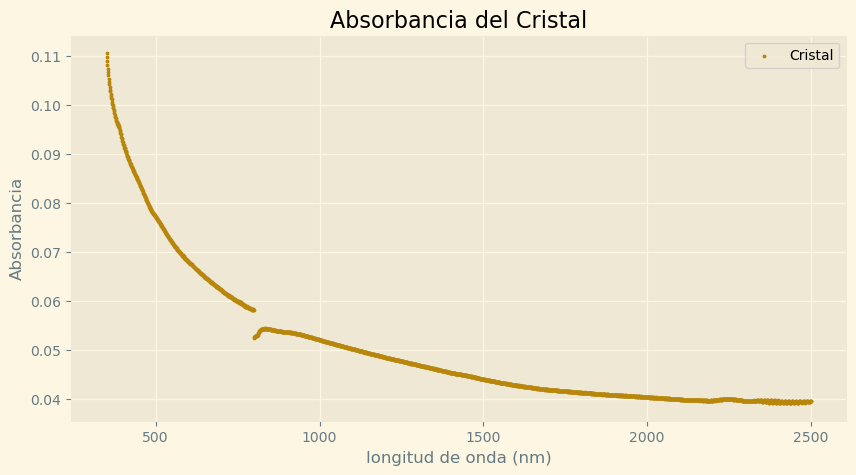

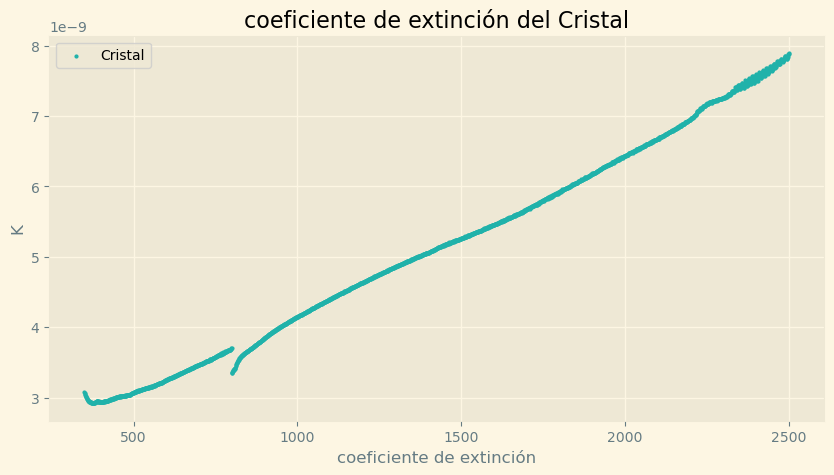

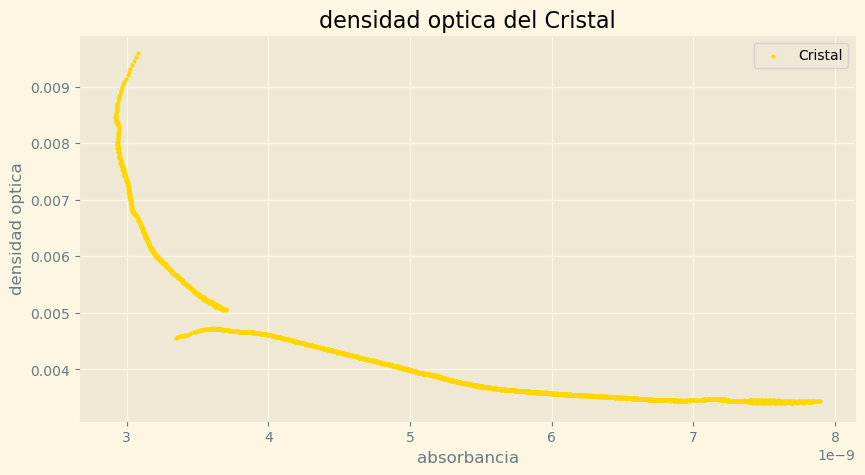

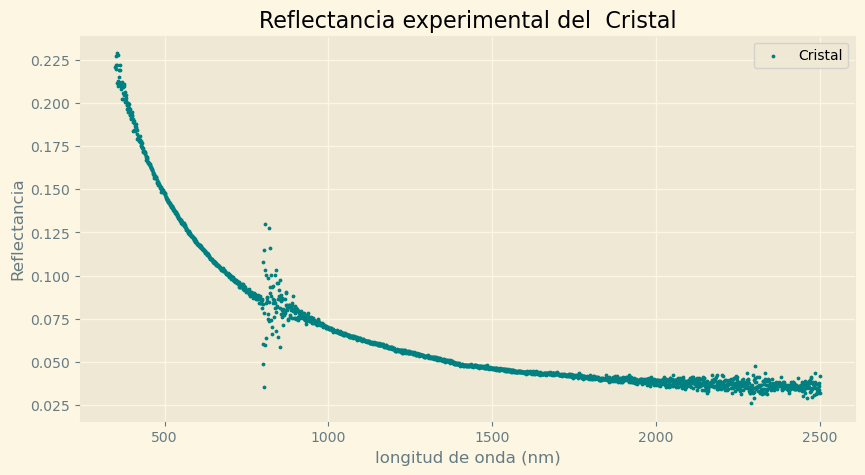

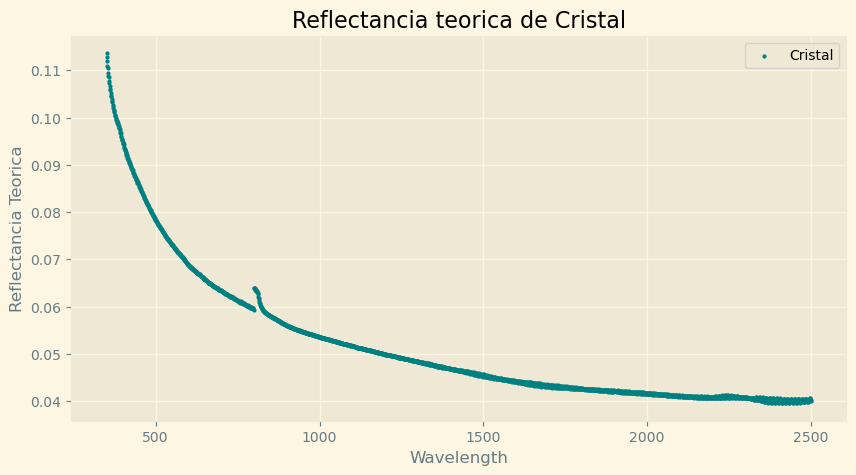

In [280]:
k_cristal=cristal.k_calc()
r_teorica_cristal = cristal.R_theoric_calc()
cristal.graph_T()
cristal.graph_abs()
cristal.graph_k(k_cristal)
cristal.graph_do(k_cristal,cristal.do_calc())
cristal.graph_R()
cristal.graph_R_Theoric(r_teorica_cristal)


# Gráficas Multiples

## Gráficas Reflectancia vs Reflectancia teórica

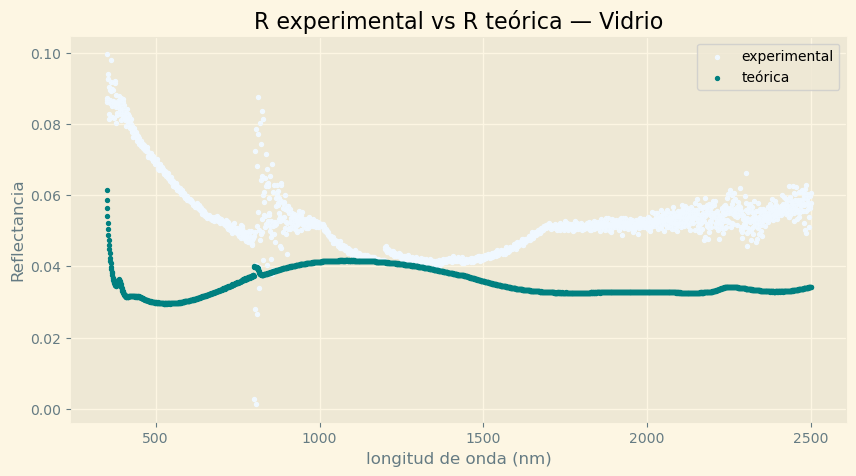

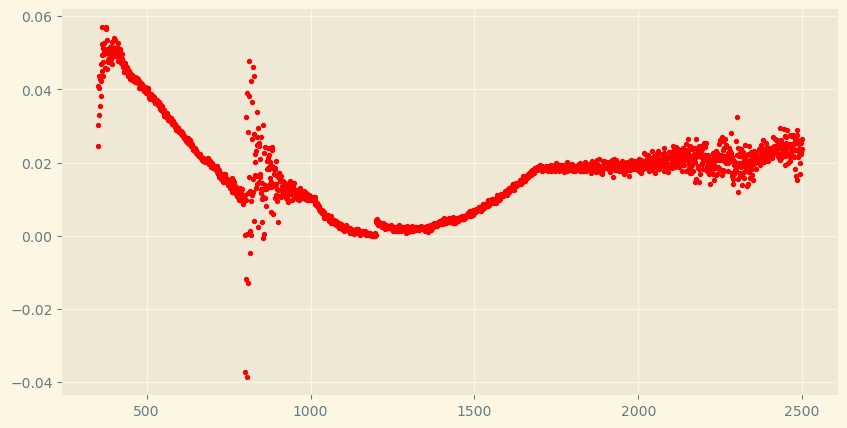

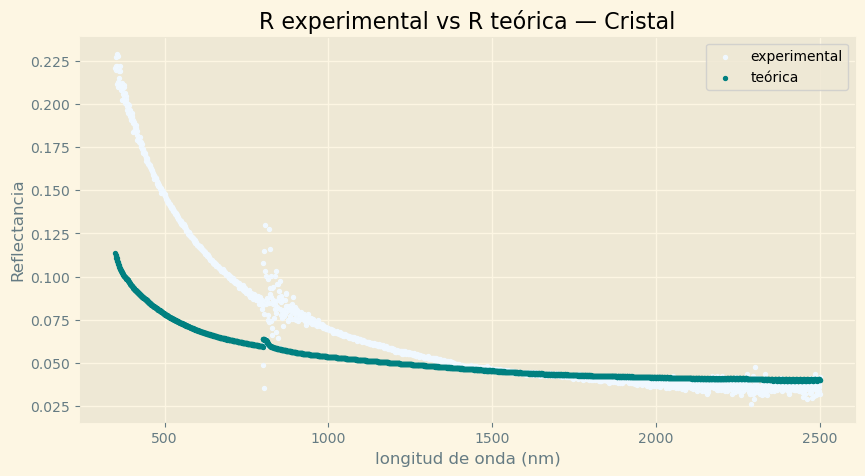

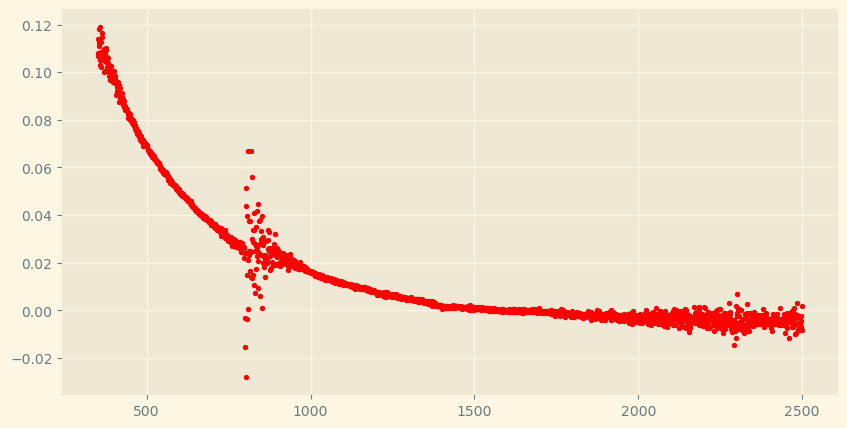

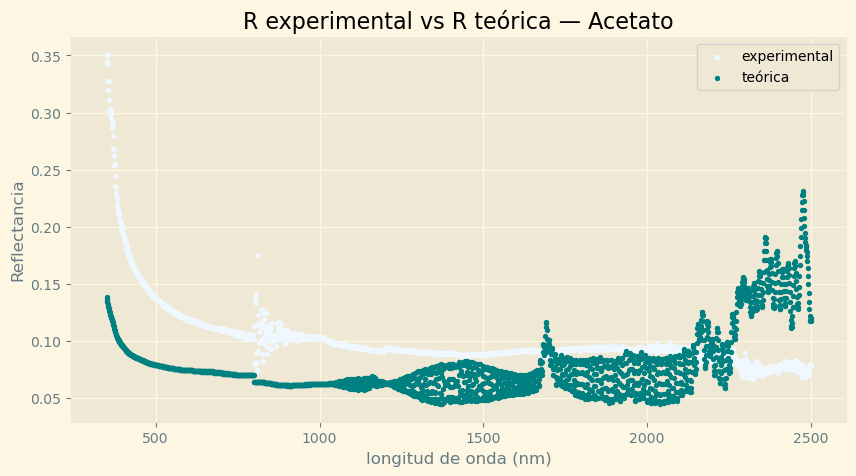

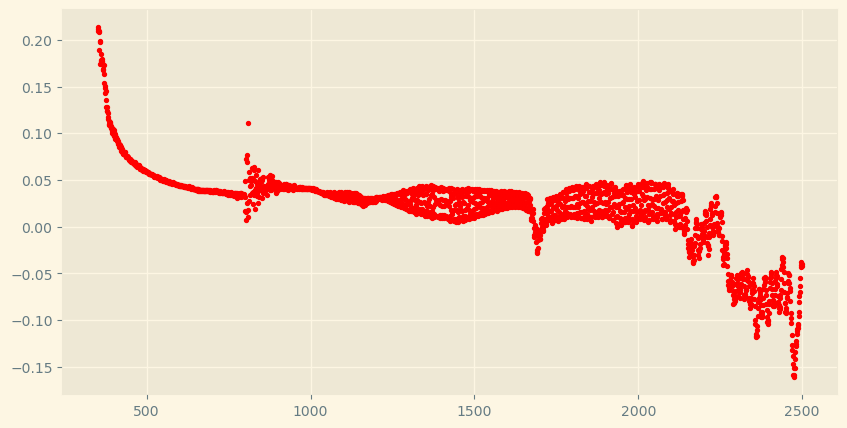

In [296]:
 vidrio.graphR_expVsTheoric(r_teorica_vidrio)
 cristal.graphR_expVsTheoric(r_teorica_cristal)
 acetato.graphR_expVsTheoric(r_teorica_acetato)
 

## Transmitancia experimental vs teórica

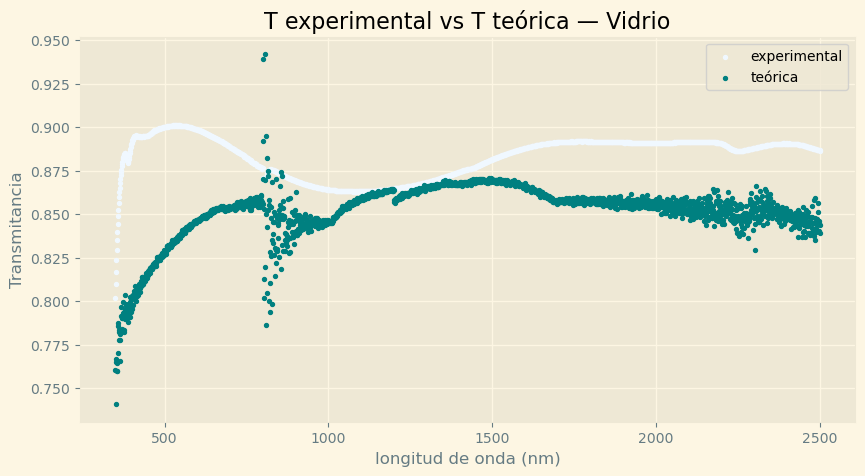

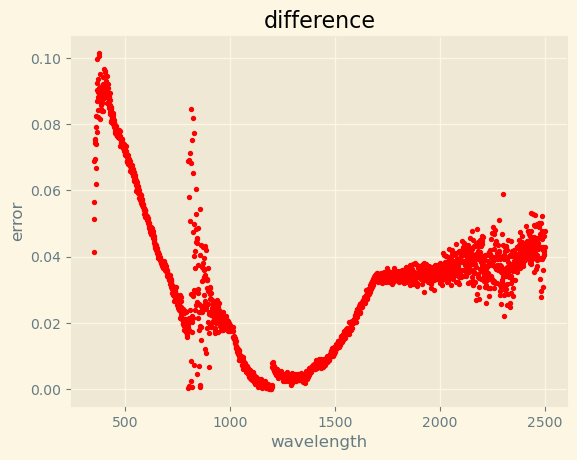

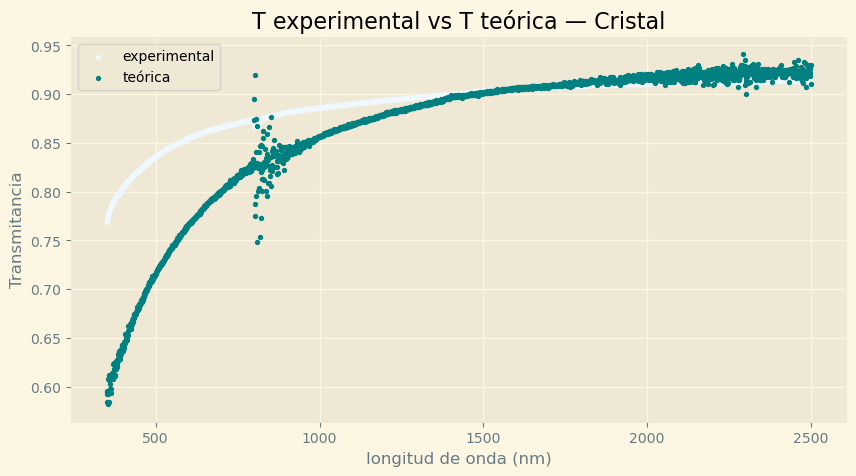

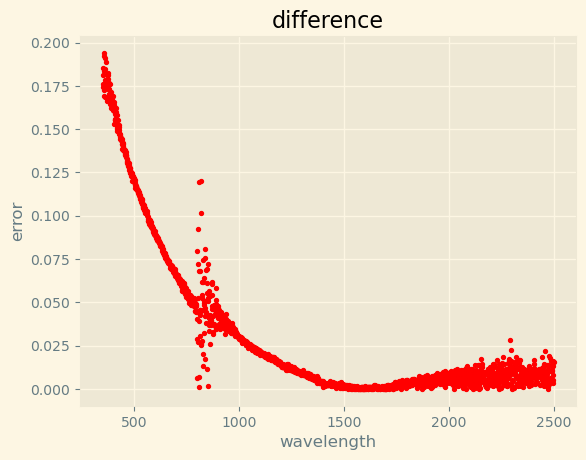

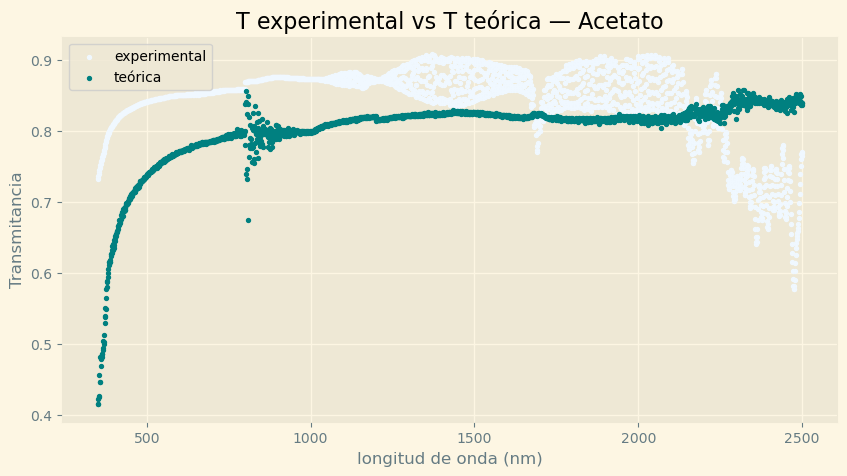

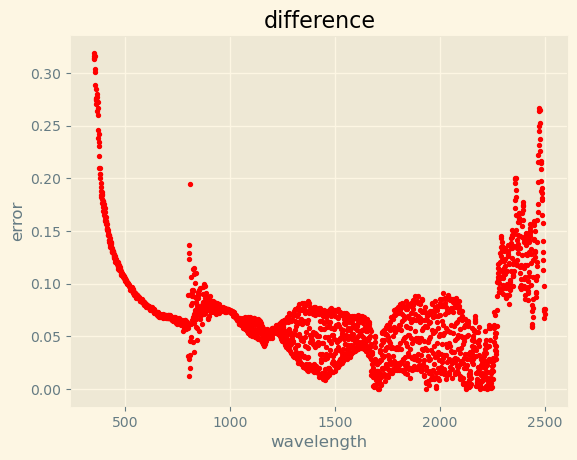

In [311]:
t_teorica_vidrio = vidrio.T_theoric_calc()
t_teorica_cristal = cristal.T_theoric_calc()
t_teorica_acetato = acetato.T_theoric_calc()
vidrio.graphT_expVsTheoric(t_teorica_vidrio)
cristal.graphT_expVsTheoric(t_teorica_cristal)
acetato.graphT_expVsTheoric(t_teorica_acetato)

## Comparación reflectancia teórica y Transmitancia

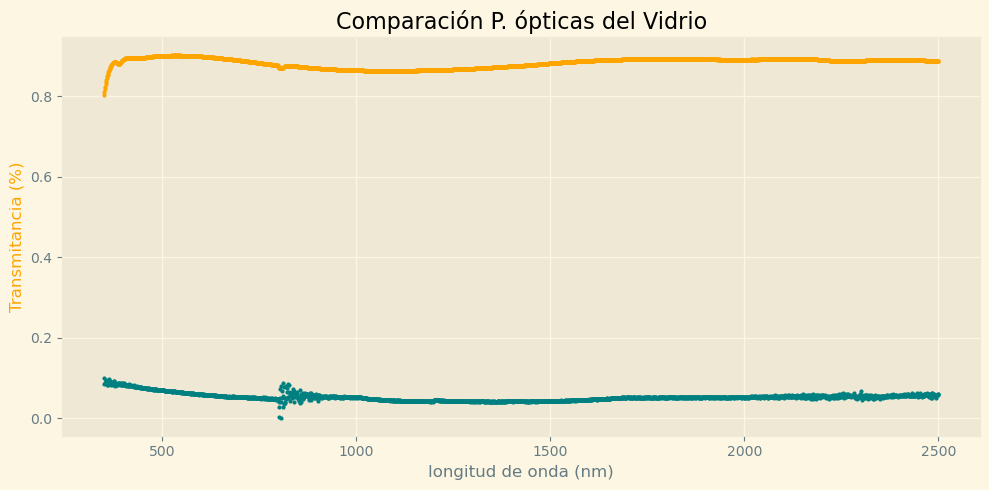

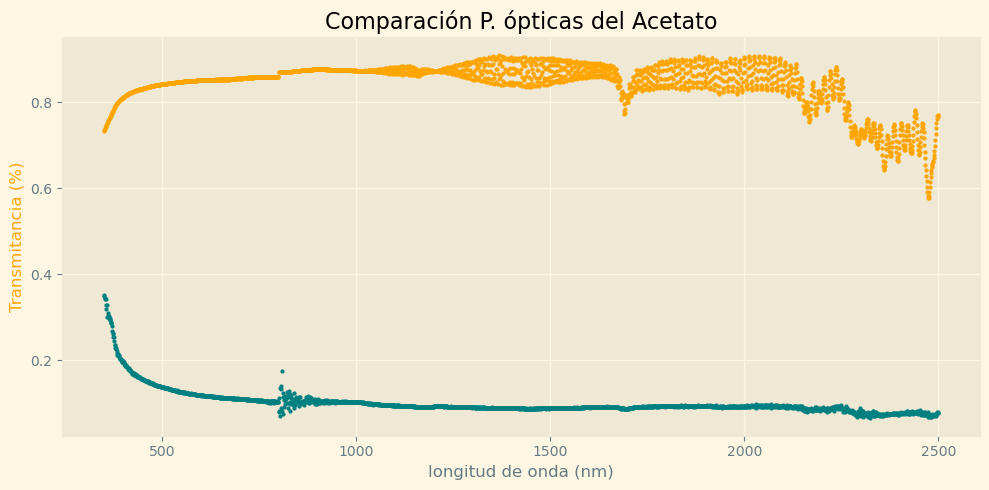

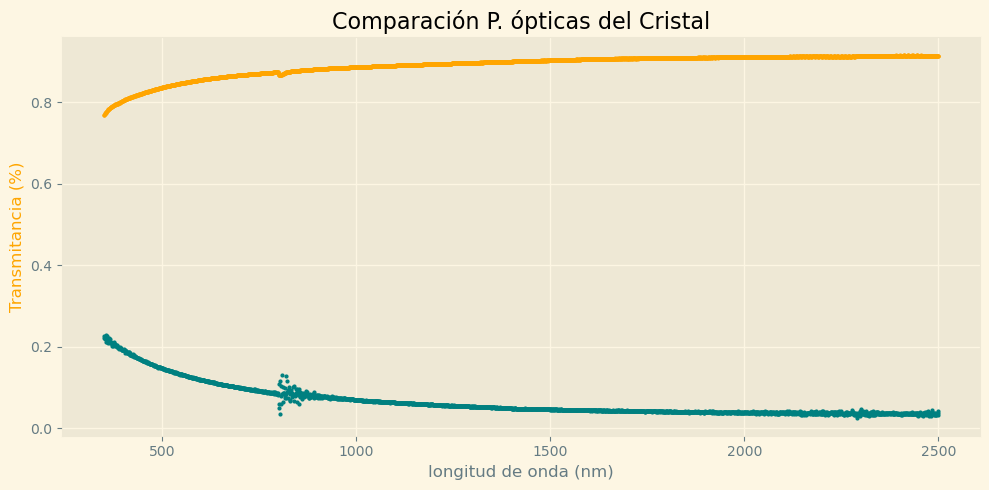

In [283]:
vidrio.multiple_graph_absT()
acetato.multiple_graph_absT()
cristal.multiple_graph_absT()

In [223]:
def prueba_de_1(material):
    """
    Función utilizada para comprobar T+ R = 1 en caso de que k sea 0  o R + T^(1/2)e^(0.5(absorbancia)*l) = 1
    """
    prueba1 = np.abs(np.power(np.e,0.5*material.absorbancia*material.l)*np.sqrt(material.transmitancia)) + material.reflectancia
    maxi = np.round(np.max(prueba1),3)
    mini = np.round(np.min(prueba1),3)
    prom = np.round(np.mean(prueba1),3)
    print(f' para el {material.name} el minimo  es {maxi} , el maximo es {mini} y el promedio es {prom}')

In [224]:
prueba_de_1(vidrio)
prueba_de_1(cristal)
prueba_de_1(acetato)

 para el Vidrio el minimo  es 1.057 , el maximo es 0.961 y el promedio es 1.017
 para el Cristal el minimo  es 1.119 , el maximo es 0.972 y el promedio es 1.015
 para el Acetato el minimo  es 1.214 , el maximo es 0.839 y el promedio es 1.022


<function matplotlib.pyplot.show(close=None, block=None)>

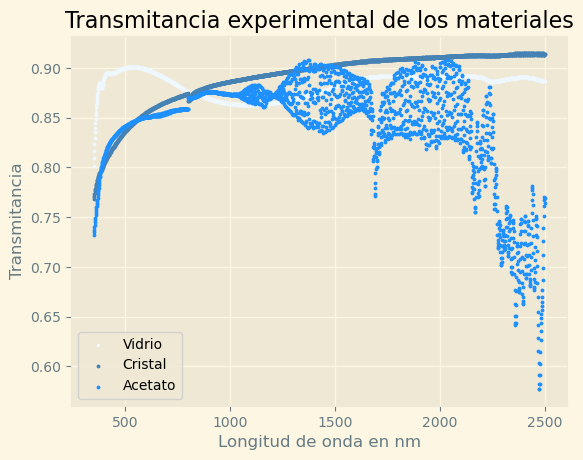

In [193]:
plt.scatter(vidrio.wavelength,vidrio.transmitancia,s=3,label=vidrio.name,color="aliceblue")
plt.scatter(vidrio.wavelength,cristal.transmitancia,s=3,label=cristal.name,color="steelblue")
plt.scatter(vidrio.wavelength,acetato.transmitancia,s=3,label=acetato.name,color="dodgerblue")
plt.xlabel("Longitud de onda en nm")
plt.ylabel("Transmitancia")
plt.title("Transmitancia experimental de los materiales")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

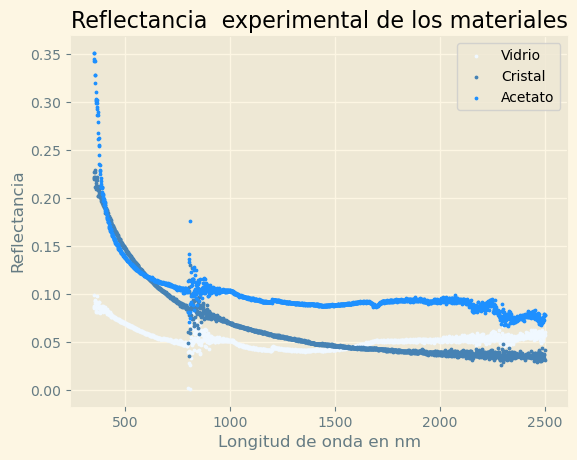

In [194]:
plt.scatter(vidrio.wavelength,vidrio.reflectancia,s=3,label=vidrio.name,color="aliceblue")
plt.scatter(vidrio.wavelength,cristal.reflectancia,s=3,label=cristal.name,color="steelblue")
plt.scatter(vidrio.wavelength,acetato.reflectancia,s=3,label=acetato.name,color="dodgerblue")
plt.xlabel("Longitud de onda en nm")
plt.ylabel("Reflectancia")
plt.title("Reflectancia  experimental de los materiales")
plt.legend()
plt.show

## Indice de refracción n en la región de transparencia

Para el calculo del Indice de refracción podemos usar la región transparente por los altos valores de Transmitancia


In [195]:
def plot_n(n_usado,color_usado,nombre):
    plt.scatter(vidrio.wavelength,n_usado,s=2,color=color_usado)
    plt.xlabel("longitud de onda en nm")
    plt.ylabel("n")
    plt.title(f'Indice de refracción del {nombre}' )
            

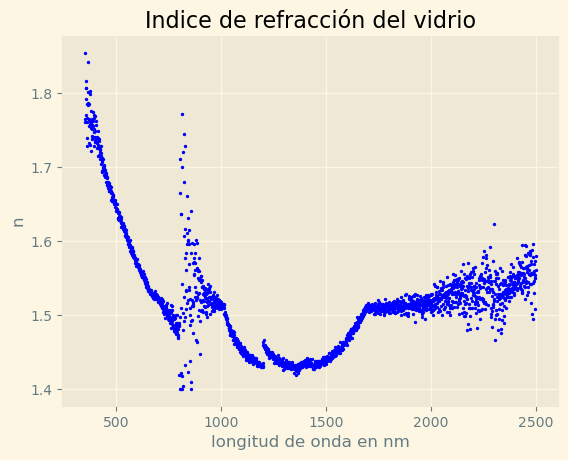

In [196]:
n_vidrio = vidrio.indice_de_refrac(vidrio.reflectancia,k_vidrio,1.4,1.9)
plot_n(n_vidrio,"blue","vidrio")

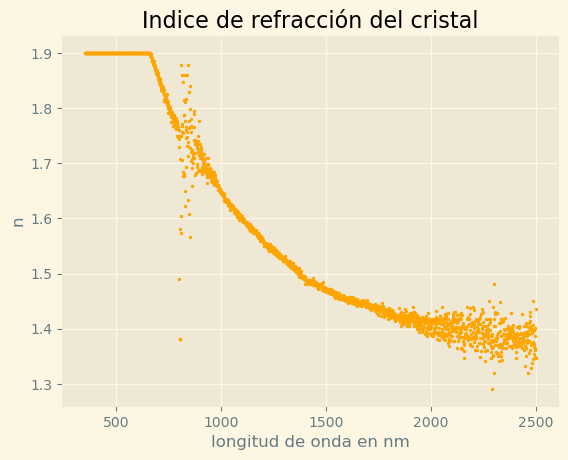

In [197]:
n_cristal = cristal.indice_de_refrac(cristal.reflectancia,k_cristal,1.2,1.9)
plot_n(n_cristal,"orange","cristal")

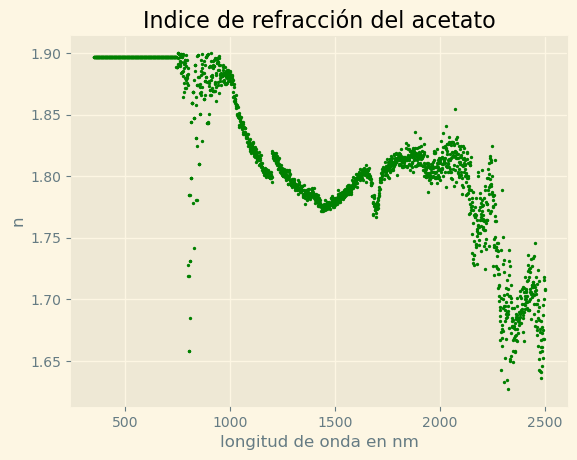

In [266]:
#n_acetato = acetato.indice_de_refrac(r_teorica_acetato,k_acetato,0.9,1.9)
n_acetato = acetato.indice_de_refrac(acetato.reflectancia,k_acetato,1,1.9)
plot_n(n_acetato,"green","acetato") 

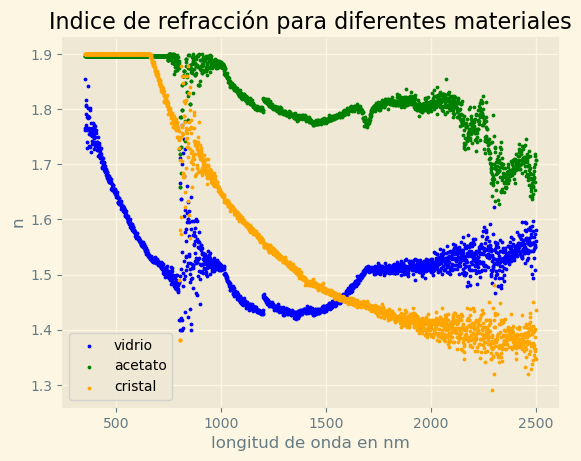

In [267]:
    plt.scatter(vidrio.wavelength,n_vidrio,label="vidrio",s=3,color="blue")
    plt.scatter(acetato.wavelength,n_acetato,label="acetato",s=3,color="green")
    plt.scatter(cristal.wavelength,n_cristal,label="cristal",s=3,color="orange")
    plt.xlabel("longitud de onda en nm")
    plt.ylabel("n")
    plt.title("Indice de refracción para diferentes materiales")
    plt.legend()

In [268]:
print(f'el indice de refracción del vidrio  encontrado es {np.round(np.mean(n_vidrio[n_vidrio > 1]),3)} comparado al aceptado {vidrio.refraction_coefficient}')
print(f'el indice de refracción del cristal  encontrado es {np.round(np.mean(n_cristal[n_vidrio > 1]),3)} ')
print(f'el indice de refracción del acetato  encontrado es {np.round(np.mean(n_acetato[n_vidrio > 1]),3)} comparado al aceptado {acetato.refraction_coefficient}')

el indice de refracción del vidrio  encontrado es 1.519 comparado al aceptado 1.5
el indice de refracción del cristal  encontrado es 1.568 
el indice de refracción del acetato  encontrado es 1.815 comparado al aceptado 1.475
